In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion
import copy

import cc3d
import torch

from monai.metrics import compute_iou
import torch.nn.functional as F

from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric, SurfaceDistanceMetric

from scipy.ndimage import distance_transform_edt

#from panoptic_measure import panoptic_quality
import numpy as np
from scipy.ndimage import label
from skimage.metrics import adapted_rand_error

import nibabel as nib

import gc
import os

In [2]:
def roll_and_fill(arr, shift, axis=None):
    """
    Roll an array along the specified axis and fill the shifted positions with zeros.

    Parameters:
    - arr: Input array.
    - shift: Number of places by which elements are shifted.
    - axis: Axis or axes along which elements are shifted. 
            By default, the array is flattened before shifting, after which the original shape is restored.

    Returns:
    - Rolled array with zeros filled in the shifted positions.
    """
    if axis is None:
        arr = arr.flatten()
        axis = 0

    result = np.zeros_like(arr)

    if isinstance(shift, int):
        shift = [shift]

    if not isinstance(axis, (tuple, list)):
        axis = [axis]

    for sh, ax in zip(shift, axis):
        if sh < 0:
            sh = arr.shape[ax] + sh

        index = [slice(None)] * arr.ndim
        if sh > 0:
            index[ax] = slice(sh, None)
            result[tuple(index)] = arr.take(indices=range(arr.shape[ax] - sh), axis=ax)
        elif sh < 0:
            index[ax] = slice(None, sh)
            result[tuple(index)] = arr.take(indices=range(-sh, arr.shape[ax]), axis=ax)
        else:
            result = arr

    return result

In [3]:
def calculate_iou(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    if union == 0:
        return 0
    return intersection / union

def panoptic_quality(pred_inp, gt_inp):
    threshold = 0.5  # Set IoU threshold to 0.5 as per the paper
    # Label connected components, ignore background!
    
    pred = pred_inp.argmax(dim=1).squeeze()
    gt = gt_inp.argmax(dim=1).squeeze()
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    #gt_labeled, gt_num = label(gt)
    #pred_labeled, pred_num = label(pred)
    
    # Track matching components and their IoU
    matches = []
    for gt_id in range(1, gt_num + 1):
        gt_component = (gt_labeled == gt_id)
        for pred_id in range(1, pred_num + 1):
            pred_component = (pred_labeled == pred_id)
            iou = calculate_iou(gt_component, pred_component)
            if iou > threshold:
                matches.append((iou, gt_id, pred_id))
    
    # Sort matches by IoU in descending order
    matches.sort(reverse=True, key=lambda x: x[0])
    
    # Track used components
    used_gt = set()
    used_pred = set()
    
    tp = 0  # True Positives
    sum_iou = 0
    
    for iou, gt_id, pred_id in matches:
        if gt_id not in used_gt and pred_id not in used_pred:
            tp += 1
            sum_iou += iou
            used_gt.add(gt_id)
            used_pred.add(pred_id)
    
    fp = pred_num - tp  # False Positives
    fn = gt_num - tp    # False Negatives
    
    # Calculate PQ
    if tp + fp + fn == 0:
        pq = 1.0
    else:
        pq = sum_iou / (tp + 0.5 * fp + 0.5 * fn)
    
    return torch.as_tensor(pq) 

In [4]:
def compute_all_metrics(cc_labels, array, s, drop_cc=False, caching_dir=".",caching_name="toy1.npy"):
    cc_dt = []

    if not drop_cc and os.path.exists(os.path.join(caching_dir,caching_name)):
        cc_asignment = np.load(os.path.join(caching_dir,caching_name))
    else:
        for cc in np.unique(cc_labels):
            if cc == 0:
                pass
            else:
                cc_dt.append(
                    distance_transform_edt(np.logical_not(cc_labels == cc)).astype(np.float32) 
                    #Convert to float 32 due to 64GB Ram limitation
                    )
        cc_asignment = np.argmin(np.stack(cc_dt),axis=0)+1
    if drop_cc:
        np.save(os.path.join(caching_dir,caching_name),cc_asignment)    
    original_labels = torch.from_numpy(array)
    cc_asignment = torch.from_numpy(cc_asignment)


    scenario_predictions = torch.from_numpy(s)
    
    cur_pred = F.one_hot(scenario_predictions.unsqueeze(0).long(),num_classes=2)
    cur_pred = cur_pred.permute(0,4,1,2,3)
    cur_labels = F.one_hot(original_labels.unsqueeze(0).long(),num_classes=2)
    cur_labels = cur_labels.permute(0,4,1,2,3)
    cur_cc_asignment = cc_asignment.unsqueeze(0)
    
    metrics = {
        "DiceMetric": DiceMetric(include_background=False, reduction="mean"),
        #"HausdorffDistance": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=None, directed=False, reduction='mean', get_not_nans=False),
        #"HausdorffDistance95": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean',percentile=95, directed=False, reduction='mean', get_not_nans=False),
        #"SurfaceDistance": SurfaceDistanceMetric(include_background=False, symmetric=False, distance_metric='euclidean', reduction='mean', get_not_nans=False),
        "SurfaceDiceMetric": SurfaceDiceMetric(class_thresholds=[1] ,include_background=False, distance_metric='euclidean', reduction='mean', get_not_nans=False, use_subvoxels=False),
        #"PanopticQuality": panoptic_quality
    }
    
    this_patients_predictions = {
        #"PatientID": "/".join(label_path.split("/")[-3:-1]),
        #"n":n,
        #"k":k,
        #"p":p,
        "nof_ccs": len(np.unique(cc_labels)),
        #"cc_indices": unique_labels.tolist(),
        #"cc_voxel_count": cc_voxel_counts.tolist(),
        #"affected_cc_regions": affected_regions_idx
    }
    
    
    #Aggregate predictions
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            pass
        else: 
            metric(y_pred=cur_pred, y=cur_labels)
    
    #Reduce predictions for this patient
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            global_metric_result = metric(cur_pred, cur_labels).item()
        else:
            global_metric_result = metric.aggregate().item()
        this_patients_predictions.update(
            {f"Global_{metric_name}":global_metric_result}
        )
        print(f"Global_{metric_name} -> {global_metric_result}")
        if metric_name !="PanopticQuality": metric.reset()
    
       
    
    cc_submetrics = {}
    
    #Report how many of the cc_regiond do not have any components
    missed_cc = 0
    
    for metric_name, metric in metrics.items():
        if metric_name !="PanopticQuality": metric.reset()
        
    for cc_id in cc_asignment.unique():
        
        pred_helper = copy.deepcopy(cur_pred).argmax(dim=1)
        label_helper = copy.deepcopy(cur_labels).argmax(dim=1)
        cc_mask = cur_cc_asignment == cc_id
        # Set the rest of gt and labels to background, to ignore during 
        pred_helper[
            torch.logical_not(cc_mask)
            ] = 0
        label_helper[
            torch.logical_not(cc_mask)
            ] = 0
        
    
        if pred_helper.sum() == 0:
            missed_cc += 1
        
        pred_helper = F.one_hot(pred_helper.long(),num_classes=2)
        pred_helper = pred_helper.permute(0,4,1,2,3)
        label_helper = F.one_hot(label_helper.long(),num_classes=2)
        label_helper = label_helper.permute(0,4,1,2,3)
    
        #Put into the the submetrics
        for metric_name, metric in metrics.items():
            
            
            if metric_name != "PanopticQuality":
                metric(y_pred=pred_helper, y=label_helper)
                submetric = metric.aggregate()
            else:
                submetric = metric(pred_helper, label_helper)
            
            if metric_name not in cc_submetrics:
                cc_submetrics.update({metric_name:[submetric.item()]})
            else:
                cc_submetrics[metric_name].append(submetric.item())
            
            if metric_name != "PanopticQuality": metric.reset()
    
            gc.collect()
    
    for metric_name, vals in cc_submetrics.items():
        aggregated_submetric = sum(vals)/len(vals)
        this_patients_predictions.update(
            {
                f"Submetric_{metric_name}_agg":aggregated_submetric,
                f"Submetric_{metric_name}_details":vals,
            }
        )
        print(f"Submetric_{metric_name} -> {aggregated_submetric}")
    this_patients_predictions.update(
        {f"Missed_cc_regions": missed_cc}
        )
    return this_patients_predictions

In [5]:
array = nib.load("array.nii.gz").get_fdata()

In [6]:
np.unique(array)

array([0., 1.])

In [7]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)

In [8]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
#structuring_element = np.ones((3,3,3), dtype=np.bool_)

#Components can be uniquely identified by their nof components
idx, counts = np.unique(cc_labels,return_counts=True)

component_to_roll = 3

print(f"Component, which is rolled is the one with {counts[component_to_roll]} elements")
count_identifier = counts[component_to_roll]

results_smallest = [compute_all_metrics(cc_labels,array,s,drop_cc=False)]

for i in range(25):
    #Isolate component
    cur_cc = cc3d.connected_components(s)
    cur_indice, cur_counts = np.unique(cur_cc, return_counts = True)

    if not np.sum(cur_counts == count_identifier) == 1:
        print("Expect 1 component to match")
        break
    
    cur_idx = cur_indice[cur_counts == count_identifier]

    #Roll subset
    rolled_component = np.roll(cur_cc==cur_idx,axis=1,shift=4)

    #Delete old
    s[cur_cc==cur_idx] = 0
    #Input new 
    s = np.logical_or(s,rolled_component)
    
    res = compute_all_metrics(cc_labels,array,s)
    results_smallest.append(res)

Component, which is rolled is the one with 33371 elements
Global_DiceMetric -> 1.0
Global_SurfaceDiceMetric -> 1.0
Submetric_DiceMetric -> 1.0
Submetric_SurfaceDiceMetric -> 1.0
Global_DiceMetric -> 0.9989519715309143
Global_SurfaceDiceMetric -> 0.9799709320068359
Submetric_DiceMetric -> 0.9503361185391744
Submetric_SurfaceDiceMetric -> 0.778605729341507
Global_DiceMetric -> 0.9979217052459717
Global_SurfaceDiceMetric -> 0.9753269553184509
Submetric_DiceMetric -> 0.9015112916628519
Submetric_SurfaceDiceMetric -> 0.7272727290789286
Global_DiceMetric -> 0.9969293475151062
Global_SurfaceDiceMetric -> 0.9731098413467407
Submetric_DiceMetric -> 0.8544844388961792
Submetric_SurfaceDiceMetric -> 0.7027653579910597
Global_DiceMetric -> 0.9960044026374817
Global_SurfaceDiceMetric -> 0.9723607897758484
Submetric_DiceMetric -> 0.8106539646784464
Submetric_SurfaceDiceMetric -> 0.6944858431816101
Global_DiceMetric -> 0.9951629638671875
Global_SurfaceDiceMetric -> 0.9717016220092773
Submetric_DiceMe

In [9]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
#structuring_element = np.ones((3,3,3), dtype=np.bool_)

#Components can be uniquely identified by their nof components
idx, counts = np.unique(cc_labels,return_counts=True)

component_to_roll = 2

print(f"Component, which is rolled is the one with {counts[component_to_roll]} elements")
count_identifier = counts[component_to_roll]

results_largest = [compute_all_metrics(cc_labels,array,s,drop_cc=True)]

for i in range(25):
    #Isolate component
    cur_cc = cc3d.connected_components(s)
    cur_indice, cur_counts = np.unique(cur_cc, return_counts = True)

    assert np.sum(cur_counts == count_identifier) == 1, "Expect 1 component to match"
    cur_idx = cur_indice[cur_counts == count_identifier]

    #Roll subset
    rolled_component = np.roll(cur_cc==cur_idx,axis=1,shift=4)

    #Delete old
    s[cur_cc==cur_idx] = 0
    #Input new 
    s = np.logical_or(s,rolled_component)
    
    res = compute_all_metrics(cc_labels,array,s)
    results_largest.append(res)

Component, which is rolled is the one with 4187707 elements
Global_DiceMetric -> 1.0
Global_SurfaceDiceMetric -> 1.0
Submetric_DiceMetric -> 1.0
Submetric_SurfaceDiceMetric -> 1.0
Global_DiceMetric -> 0.9735316634178162
Global_SurfaceDiceMetric -> 0.48752865195274353
Submetric_DiceMetric -> 0.9900047183036804
Submetric_SurfaceDiceMetric -> 0.7801492313543955
Global_DiceMetric -> 0.9470835328102112
Global_SurfaceDiceMetric -> 0.3636690378189087
Submetric_DiceMetric -> 0.9800170660018921
Submetric_SurfaceDiceMetric -> 0.7270133246978124
Global_DiceMetric -> 0.9206674695014954
Global_SurfaceDiceMetric -> 0.31815797090530396
Submetric_DiceMetric -> 0.9700415134429932
Submetric_SurfaceDiceMetric -> 0.7074890260895094
Global_DiceMetric -> 0.8943171501159668
Global_SurfaceDiceMetric -> 0.29538747668266296
Submetric_DiceMetric -> 0.9600908160209656
Submetric_SurfaceDiceMetric -> 0.697720450659593
Global_DiceMetric -> 0.8680545687675476
Global_SurfaceDiceMetric -> 0.2808862626552582
Submetric_D

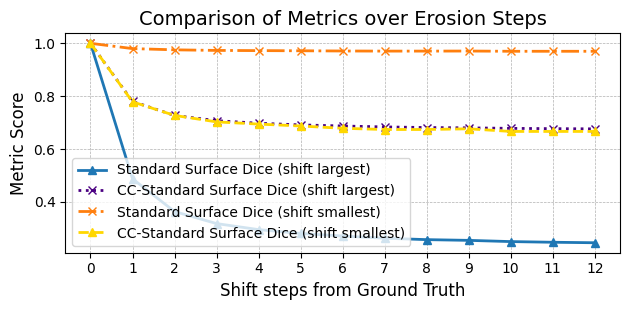

In [10]:
#plt.plot([x["Global_SurfaceDiceMetric"] for x in results_largest], label="Standard Surface Dice", linewidth=2, marker='o')
#plt.plot([x["Submetric_SurfaceDiceMetric_agg"] for x in results_largest], label="CC-Surface Dice", linewidth=2, marker='s')
#plt.plot([x["Global_PanopticQuality"] for x in results_smallest], label="Panoptic Quality", linewidth=2, marker='^')

#plt.plot([x["Global_SurfaceDiceMetric"] for x in results_smallest], label="Standard Surface Dice", linewidth=2, marker='o')
#plt.plot([x["Submetric_SurfaceDiceMetric_agg"] for x in results_smallest], label="CC-Surface Dice", linewidth=2, marker='s')

plt.figure(figsize=(6.4, 3.2))

plt.plot(
    [x["Global_SurfaceDiceMetric"] for x in results_largest[:13]],
    label="Standard Surface Dice (shift largest)",
    linewidth=2,
    marker='^',
    #color='b',  # Blue color
    linestyle='-'
)
plt.plot(
    [x["Submetric_SurfaceDiceMetric_agg"] for x in results_largest[:13]],
    label="CC-Standard Surface Dice (shift largest)",
    linewidth=2,
    marker='x',
    color='Indigo',  # Magenta color
    linestyle=':'
)

# Second subplot
plt.plot(
    [x["Global_SurfaceDiceMetric"] for x in results_smallest[:13]],
    label="Standard Surface Dice (shift smallest)",
    linewidth=2,
    marker='x',
    #color='g',  # Green color
    linestyle='-.',
    #alpha=0.2
)
plt.plot(
    [x["Submetric_SurfaceDiceMetric_agg"] for x in results_smallest[:13]],
    label="CC-Standard Surface Dice (shift smallest)",
    linewidth=2,
    marker='^',
    color='Gold',  # Red color
    linestyle='--',
)



# Add gridlines
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Add legend with better placement
plt.legend(loc="best", fontsize=10, frameon=True)

# Set axis labels with larger fonts
plt.ylabel("Metric Score", fontsize=12)
plt.xlabel("Shift steps from Ground Truth", fontsize=12)

# Set x-ticks
plt.xticks(ticks=range(0, 13), labels=range(13), fontsize=10)

# Improve the format of y-axis tick labels
#plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Set the plot's title
plt.title("Comparison of Metrics over Erosion Steps", fontsize=14)

# Save the plot as a high-resolution image
plt.tight_layout()
#plt.savefig("SD_vs_CC_SD_Dice_small_small.pdf")